In [37]:
import os
import io
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Read data 

In [2]:
data = pd.read_csv('Data/IMDB_Dataset.csv')

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Convert sentiment column to int

In [4]:
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

### Split data

In [5]:
# Shuffle the DataFrame
shuffled_data = data.sample(frac=1, random_state=2023)  

train_size = 0.8  # 80% for training, 20% for testing
train_data, test_data = train_test_split(shuffled_data, train_size=train_size, random_state=2023)

In [6]:
print(f'Train shappe: {train_data.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Test shappe: (10000, 2)


In [7]:
X_train = train_data['review']
y_train = train_data['sentiment']

X_test = test_data['review']
y_test = test_data['sentiment']

### Preprocessing - Clean text
* Remove stopwords
* Remove punctuations
* Remove html tags

In [8]:
# using stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gcerri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
table = str.maketrans('', '', string.punctuation)

In [10]:
X_train_cleaned = []

for item in tqdm(X_train):
    sentence = str(item).lower()
    # if we have 2 joined words 
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    # remove <br> tag
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    # remove stop words and punctuations
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table) # remove all punctuations
        if word not in stop_words:
            filtered_sentence += word + ' '
    
    X_train_cleaned.append(filtered_sentence.strip())

  2%|▋                                    | 801/40000 [00:00<00:14, 2667.58it/s]/var/folders/mq/cmjp1vmd5f1fdgxg3fzz2rb00000gq/T/ipykernel_92405/3557040181.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)
100%|███████████████████████████████████| 40000/40000 [00:17<00:00, 2278.29it/s]


### See sentences length distribution

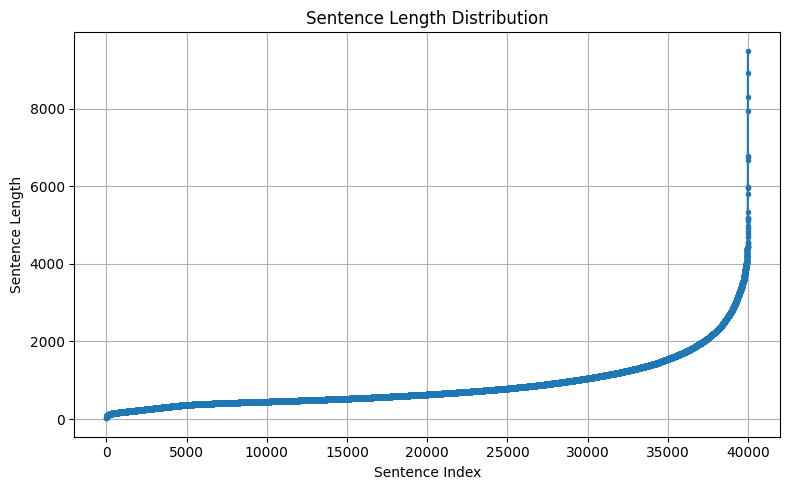

In [11]:
sentence_lengths = [len(sentence) for sentence in X_train_cleaned]
sorted_lengths = sorted(sentence_lengths)

x_values = list(range(1, len(X_train_cleaned) + 1))

# Creiamo il grafico
plt.figure(figsize=(8, 5))  
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')  
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)  
plt.tight_layout()  
plt.show()

### Zoom on the left part

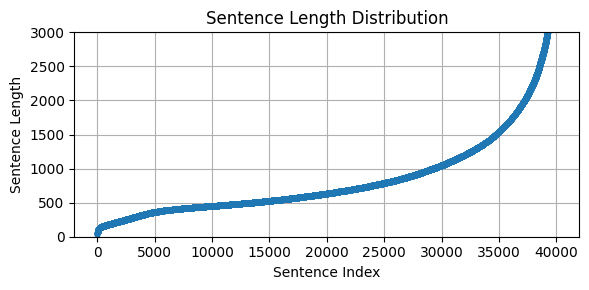

In [12]:
# Creiamo il grafico
plt.figure(figsize=(6, 3))  
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')  
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)  
plt.tight_layout()
plt.ylim(0, 3000)
plt.show()

**most of the sentences have less than 2000 words and 1000 words** 

### Check the total set of words

In [13]:
all_words = [word for sentence in X_train_cleaned for word in sentence.split()]

# Calculate the vocabulary size (number of unique words)
total_vocab_size = len(set(all_words))

print("Total Vocabulary Size:", total_vocab_size)

Total Vocabulary Size: 110114


### Tokenization

In [14]:
vocab_size = 50000
max_length = 2000
trunc_type='post'
padding_type='post'
oov_tok = ""

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_cleaned)

In [16]:
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### WordCloud

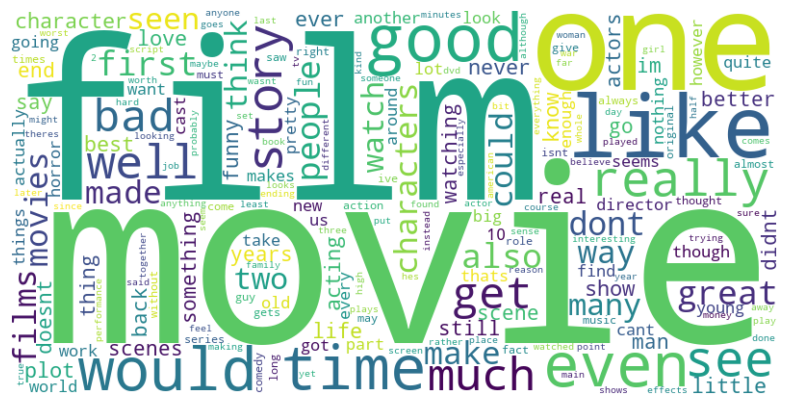

In [23]:
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
word_counts = tokenizer.word_counts
wordcloud.generate_from_frequencies(word_counts)
wordcloud.to_file("doc/header.png")

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

seems we have done a good cleaning 

### Split the train into train and validation
Using 80% for train and 20% for test

In [24]:
training_padded, validation_padded, y_train, y_valid = train_test_split(training_padded, y_train, test_size=0.2, random_state=2023)

In [25]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)

validation_padded = np.array(validation_padded)
validation_labels = np.array(y_valid)

testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [26]:
print(f'Train shappe: {train_data.shape}')
print(f'Validation shappe: {validation_padded.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Validation shappe: (8000, 2000)
Test shappe: (10000, 2)


### Define the neural network

In [27]:
embedding_dim = round(vocab_size ** 0.25) # use the fourth root of the vocab size
l2_regularization = 0.01 # tends to amplify differences between nonzero values and zero or close-tozero ones

In [34]:
def create_model(vocab_size, embedding_dim):
    model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim), # turns positive integers into dense vectors of fixed size
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
            tf.keras.layers.Dropout(.25),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [35]:
model = create_model(vocab_size, embedding_dim)
# Display the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 15)          750000    
                                                                 
 global_average_pooling1d_1  (None, 15)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                384       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 750409 (2.86 MB)
Trainable params: 750409 (2.86 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [47]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [48]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

In [49]:
num_epochs = 100
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels), 
                    verbose=2,
                    callbacks=[cp_callback])

Epoch 1/100
1000/1000 - 9s - loss: 0.5882 - accuracy: 0.8079 - val_loss: 0.5829 - val_accuracy: 0.8474 - 9s/epoch - 9ms/step
Epoch 2/100
1000/1000 - 15s - loss: 0.5815 - accuracy: 0.8104 - val_loss: 0.5764 - val_accuracy: 0.8499 - 15s/epoch - 15ms/step
Epoch 3/100
1000/1000 - 16s - loss: 0.5754 - accuracy: 0.8131 - val_loss: 0.5700 - val_accuracy: 0.8516 - 16s/epoch - 16ms/step
Epoch 4/100
1000/1000 - 15s - loss: 0.5682 - accuracy: 0.8160 - val_loss: 0.5633 - val_accuracy: 0.8510 - 15s/epoch - 15ms/step
Epoch 5/100

Epoch 5: saving model to training/cp-0005.ckpt
1000/1000 - 11s - loss: 0.5637 - accuracy: 0.8166 - val_loss: 0.5573 - val_accuracy: 0.8500 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 13s - loss: 0.5564 - accuracy: 0.8235 - val_loss: 0.5512 - val_accuracy: 0.8570 - 13s/epoch - 13ms/step
Epoch 7/100
1000/1000 - 14s - loss: 0.5509 - accuracy: 0.8239 - val_loss: 0.5454 - val_accuracy: 0.8499 - 14s/epoch - 14ms/step
Epoch 8/100
1000/1000 - 16s - loss: 0.5454 - accuracy: 0.82

### Save the entire model

In [50]:
model.save('model/sentiment_model_v1')

INFO:tensorflow:Assets written to: model/sentiment_model_v1/assets


INFO:tensorflow:Assets written to: model/sentiment_model_v1/assets


### Plot accuracy and loss during training

In [51]:
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

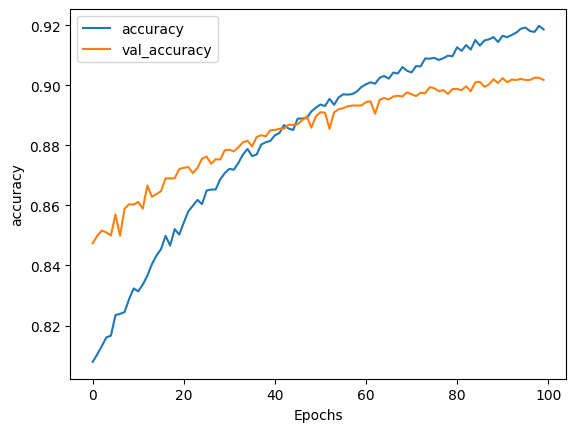

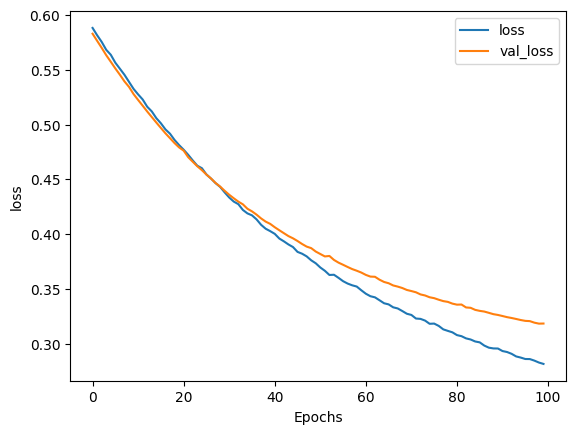

In [52]:
plot_history(history, "accuracy")
plot_history(history, "loss")

### Evaluate the model

In [54]:
model.evaluate(testing_padded, testing_labels, verbose=2)

313/313 - 1s - loss: 0.8839 - accuracy: 0.6521 - 562ms/epoch - 2ms/step


[0.883934497833252, 0.6521000266075134]

### Make predictions

In [56]:
sentences = ["I recently watched it, and it's absolutely fantastic. The acting, direction, and storytelling are all top-notch. I highly recommend it.", 
             "I watched it and was let down. The acting felt flat, and the story was uninspiring. I wouldn't recommend it."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 20ms/step
[[0.7700121 ]
 [0.31945133]]


seems to work

### Visualizing the Embeddings

To visualize the embeddings we use this tool: https://projector.tensorflow.org/

This tool requires 2 inpiut file:
    
    * TSV file for the vectors 
    * TSV file for metadata (optional)

In [57]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [58]:
e = model.layers[0]
weights = e.get_weights()[0]

In [77]:
out_v = io.open('data/vector.tsv', 'w', encoding='utf-8')
out_m = io.open('data/metadata.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

### This is the result for the embedding

![Embedding](doc/Embedding.png)